<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/003_TensorFlow_Proj_Three_FFNN_PolynomialCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [201]:
# utils
import itertools
import glob, os, sys, shutil
import math
import numpy as np
import pandas as pd
from random import (randint, sample, choice)
# google
from google.colab import drive
# display
from IPython.display import Image
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (Sequential, load_model)
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPool2D,
                                     AvgPool2D, Activation, Input,
                                     BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (CategoricalCrossentropy,
                                      SparseCategoricalCrossentropy,
                                      BinaryCrossentropy)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
# matplotlib
import matplotlib.pyplot as plt

## Setup

In [202]:
# setup gpu
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set for device:", physical_devices[0])
    except Exception as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


## BiLinear Model

In [203]:
# gen sample
def bi_linear(samples):
  # red points
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue points
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # stack and return df
  final= np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])

# define colors
color_dict = {0: 'red', 1: 'blue'}
# train df
n_train =1000
train_df = bi_linear(n_train)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
n_test = 200
test_df = bi_linear(n_test)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save data frames
graph = 'linear'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

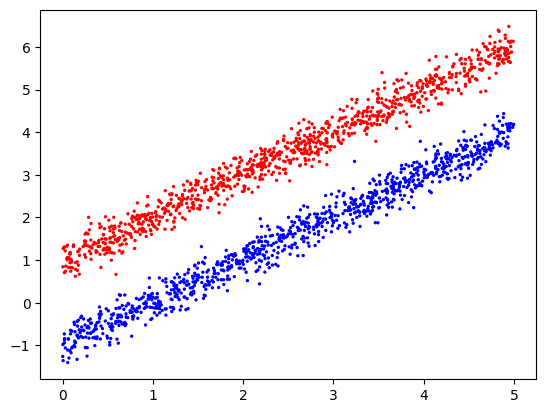

In [204]:
# plot
plt.figure()
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)
plt.show()

In [205]:
# shuffle
np.random.shuffle(train_df.values)

In [206]:
print(train_df.head())

          x         y color
0  0.047799  1.034052   red
1  3.119187  4.031732   red
2  4.733356  6.082827   red
3  3.398748  4.305120   red
4  4.119751  5.213215   red


### Sparse Categorical Crossentropy

In [207]:
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values
test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values

In [208]:
print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (2000, 2)
train_y shape: (2000, 1)
test_x shape: (400, 2)
test_y shape: (400, 1)


In [209]:
print(train_y)

[[ True]
 [ True]
 [ True]
 ...
 [False]
 [False]
 [False]]


In [210]:
# shallow N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3387 - loss: 0.8467
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6461 - loss: 0.6781
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9277 - loss: 0.5674
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9674 - loss: 0.4906
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9994 - loss: 0.4226
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9989 - loss: 0.3721
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9964 - loss: 0.3280
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9972 - loss: 0.2702
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9977 - loss: 0.2335
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9988 - loss: 0.2013


In [211]:
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

EVALUATION
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.1782  


[0.18436527252197266, 1.0]

In [212]:
# prediction
print("PREDICTION")
pred = model.predict(test_x)
print(pred.shape)

PREDICTION
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(400, 2)


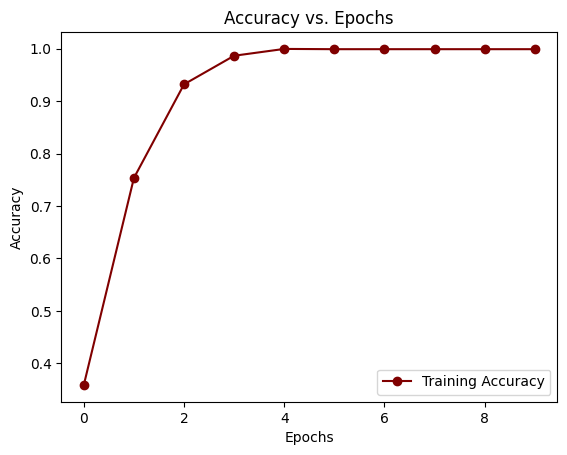

In [213]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='maroon', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

### BinaryCrossentropy

In [214]:
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = train_df.color.map({'red': 0, 'blue': 1}).values
test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = test_df.color.map({'red': 0, 'blue': 1}).values

In [215]:
print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (2000, 2)
train_y shape: (2000,)
test_x shape: (400, 2)
test_y shape: (400,)


In [216]:
print(train_y)

[0 0 0 ... 1 1 1]


In [217]:
# shallow N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
	keras.layers.Dense(1, activation="sigmoid")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="binary_crossentropy",
	          metrics=['accuracy'])
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5460 - loss: 0.7032
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5588 - loss: 0.6955
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6023 - loss: 0.6695
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6237 - loss: 0.6616
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6436 - loss: 0.6533
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6406 - loss: 0.6459
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6524 - loss: 0.6324
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6863 - loss: 0.6126
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6951 - loss: 0.6030
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7377 - loss: 0.5866


In [218]:
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

EVALUATION
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8983 - loss: 0.5088  


[0.55609530210495, 0.7649999856948853]

In [219]:
# prediction
print("PREDICTION")
pred = model.predict(test_x)
print(pred.shape)

PREDICTION
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(400, 1)


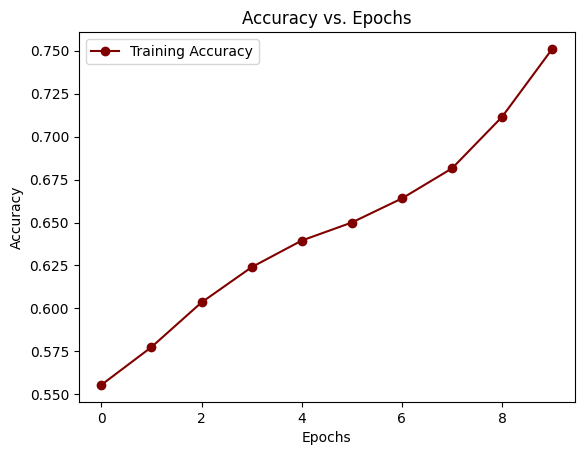

In [220]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='maroon', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## TriLines Model

In [221]:
def three_lines(samples):
  # red
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # green
  x3 = np.random.uniform(0,5,samples)
  y3 = x3 - np.random.normal(5,0.25, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # stack and return
  final= np.row_stack((red,blue,green))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
# train df
train_df = three_lines(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
test_df = three_lines(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save data frames
graph = 'linear_multigroup'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

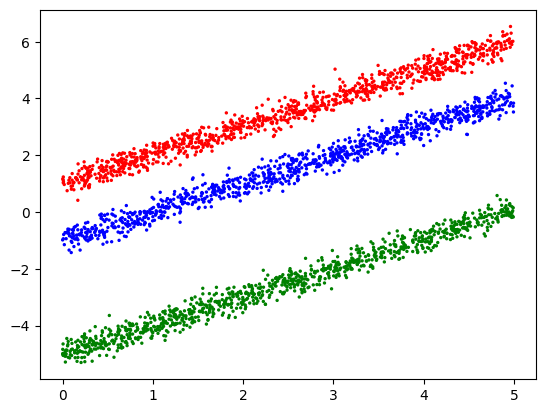

In [222]:
# plot
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [223]:
# shuffle
np.random.shuffle(train_df.values)

In [224]:
print(train_df.head())

          x         y color
0  0.624594  1.810447   red
1  3.837618  4.931584   red
2  0.214445  1.530350   red
3  3.821462  5.065775   red
4  2.498001  3.780794   red


In [225]:
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=False).values
test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=False).values

In [226]:
print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (3000, 2)
train_y shape: (3000, 3)
test_x shape: (600, 2)
test_y shape: (600, 3)


In [227]:
print(train_y)

[[False False  True]
 [False False  True]
 [False False  True]
 ...
 [False  True False]
 [False  True False]
 [False  True False]]


In [228]:
# deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(3, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="categorical_crossentropy",
	          metrics=['accuracy'])

# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10)
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4327 - loss: 1.0830
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6425 - loss: 0.8295
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7085 - loss: 0.6971
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7615 - loss: 0.5853
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8244 - loss: 0.5020
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8937 - loss: 0.4343
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9250 - loss: 0.3848
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9418 - loss: 0.3118
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9465 - loss: 0.2548
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9463 - loss: 0.2105
EVALUATION
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9743 - loss: 0.1898  


[0.18075492978096008, 0.9649999737739563]

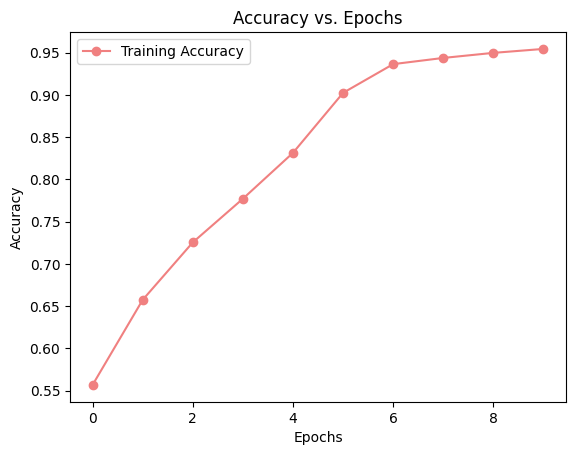

In [229]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='lightcoral', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Quadratic Model

In [230]:
def quadratic(samples):
  # Red
  x1 = np.random.uniform(-5,5, samples)
  y1 = x1**2 + np.random.uniform(1,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # Blue
  x2 = np.random.uniform(-5,5,samples)
  y2 = x2**2 - np.random.uniform(1,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # Stack and return
  final = np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue'}
# Train df
train_df = quadratic(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# Test df
test_df = quadratic(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# Save data frames
graph = 'quadratic'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

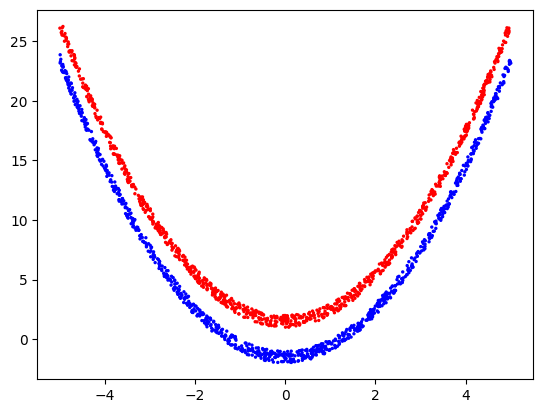

In [231]:
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [232]:
# shuffle
np.random.shuffle(train_df.values)

In [233]:
print(train_df.head())

          x          y color
0 -2.938332   9.864159   red
1  0.157027   2.010531   red
2  4.284036  19.502946   red
3  2.694974   8.980610   red
4  3.046878  11.153723   red


In [234]:
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values
test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values

In [235]:
print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (2000, 2)
train_y shape: (2000, 1)
test_x shape: (400, 2)
test_y shape: (400, 1)


In [236]:
print(train_y)

[[ True]
 [ True]
 [ True]
 ...
 [False]
 [False]
 [False]]


### Sparse Categorical Crossentropy

In [237]:
# deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5777 - loss: 0.7366
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7153 - loss: 0.6317
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6678 - loss: 0.5954
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6969 - loss: 0.5593
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7225 - loss: 0.5315
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7435 - loss: 0.5067
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7953 - loss: 0.4959
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7692 - loss: 0.4876
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7978 - loss: 0.4632
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8377 - loss: 0.4386


In [238]:
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

EVALUATION
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9502 - loss: 0.4588  


[0.4077579379081726, 0.8999999761581421]

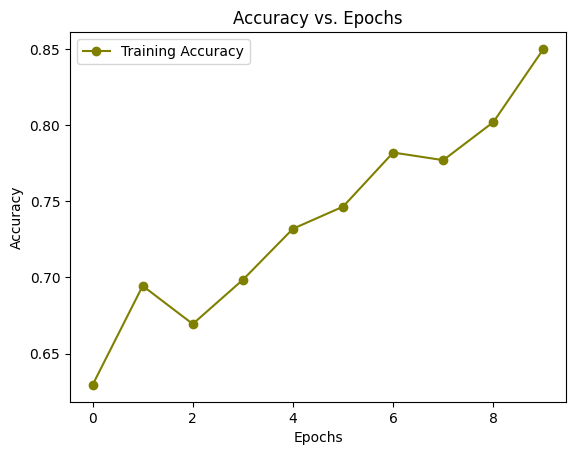

In [239]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='olive', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

### BinaryCrossentropy

In [240]:
# deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(1, activation="sigmoid")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="binary_crossentropy",
	          metrics=['accuracy'])
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5313 - loss: 0.7005
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7303 - loss: 0.6561
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6765 - loss: 0.6189
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7000 - loss: 0.5858
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7171 - loss: 0.5512
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7324 - loss: 0.5401
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7389 - loss: 0.5114
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7620 - loss: 0.4995
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7715 - loss: 0.4911
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7684 - loss: 0.4742


In [241]:
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

EVALUATION
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9067 - loss: 0.4782  


[0.43990036845207214, 0.8050000071525574]

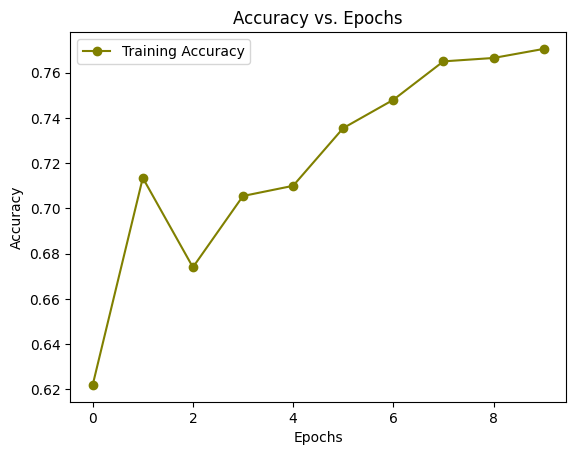

In [242]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='olive', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Cluster  Model

In [243]:
def clusters(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  teal = np.column_stack((x4,y4,z4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  orange = np.column_stack((x5,y5,z5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  purple = np.column_stack((x6,y6,z6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
# train df
train_df = clusters(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
test_df = clusters(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save frames
graph = 'clusters_multi_categories'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

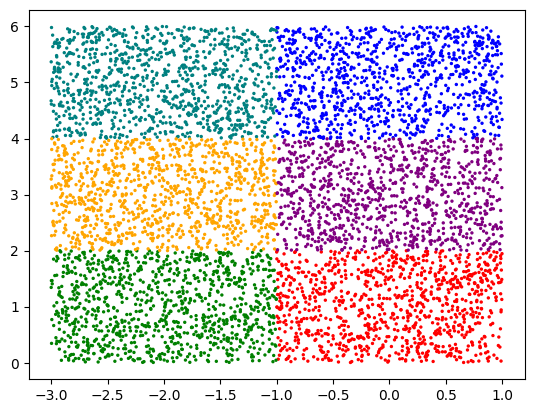

In [244]:
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [245]:
# enumerate colors
color_dict = {'red': 0, 'blue': 1, 'green': 2, 'teal': 3, 'orange': 4, 'purple': 5}
train_df['color'] = train_df.color.apply(lambda x: color_dict[x])

In [246]:
# shuffle
np.random.shuffle(train_df.values)
print(train_df.head())
print(train_df.color.unique())

          x         y  color
0 -0.241834  0.133056      0
1  0.243146  1.388275      0
2  0.712302  1.219078      0
3 -0.847073  1.473651      0
4  0.819316  0.425036      0
[0 1 2 3 4 5]


In [247]:
# stack features
train_x = np.column_stack((train_df.x.values, train_df.y.values))
test_x = np.column_stack((test_df.x.values, test_df.y.values))

In [248]:
print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x shape: {train_df.color.values.shape}")
print(f"test_y shape: {test_df.color.values.shape}")

train_x shape: (6000, 2)
train_y shape: (2000, 1)
test_x shape: (6000,)
test_y shape: (1200,)


In [249]:
print(train_df.color.values)

[0 0 0 ... 5 5 5]


In [250]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(6, activation='softmax')])
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(train_x, train_df.color.values, batch_size=5, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6285 - loss: 0.9986
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9488 - loss: 0.1949
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9636 - loss: 0.1348
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9727 - loss: 0.1037
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9677 - loss: 0.0978
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9694 - loss: 0.0869
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9615 - loss: 0.0910
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9748 - loss: 0.0716
Epoch 9/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9669 - loss: 0.0779
Epoch 10/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9776 - loss: 0.0672


In [251]:
# evaluate
print("EVALUATION")
test_df['color'] = test_df.color.apply(lambda x: color_dict[x])
model.evaluate(test_x, test_df.color.values)
print("Prediction", np.round(model.predict(np.array([[0,3]]))))

EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9868 - loss: 0.0495  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Prediction [[0. 0. 0. 0. 0. 1.]]


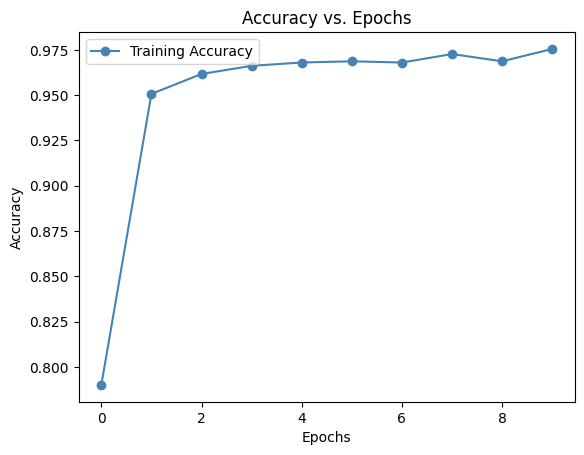

In [252]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='steelblue', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Cluster Model - OneHot Encoder

In [253]:
def clusters_advanced(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  m1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1,m1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  m2 = np.zeros(y2.shape)
  blue = np.column_stack((x2,y2,z2,m2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  m3 = np.ones(y3.shape)
  green = np.column_stack((x3,y3,z3,m3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  m4 = np.ones(y4.shape)
  teal = np.column_stack((x4,y4,z4,m4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  m5 = np.ones(y5.shape)
  orange = np.column_stack((x5,y5,z5,m5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  m6 = np.ones(y6.shape)*2
  purple = np.column_stack((x6,y6,z6,m6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color','marker'])

# color and marker codes
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
marker_dict = {0: '*', 1: 'o', 2:'s'}

# train df
train_df = clusters_advanced(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
train_df['marker'] = train_df.marker.apply(lambda x: marker_dict[int(x)])
# test df
test_df = clusters_advanced(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
test_df['marker'] = test_df.marker.apply(lambda x: marker_dict[int(x)])
# save dfs
graph = 'clusters_two_targets'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

In [254]:
# one-hot encoders
train_one_hot_color = pd.get_dummies(train_df.color).values
train_one_hot_marker = pd.get_dummies(train_df.marker).values
test_one_hot_color = pd.get_dummies(test_df.color).values
test_one_hot_marker = pd.get_dummies(test_df.marker).values
# stack targets
train_labels = np.concatenate((train_one_hot_color, train_one_hot_marker),
                              axis=1)
test_labels = np.concatenate((test_one_hot_color, test_one_hot_marker),
                             axis=1)
# stack x and y in np.array
x = np.column_stack((train_df.x.values, train_df.y.values))

In [255]:
# shuffle
np.random.RandomState(seed=42).shuffle(x)
np.random.RandomState(seed=42).shuffle(train_labels)

In [256]:
print(f"train_x shape: {x.shape}")
print(f"train_y shape: {train_labels.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_labels.shape}")

train_x shape: (6000, 2)
train_y shape: (6000, 9)
test_x shape: (1200, 2)
test_y shape: (1200, 9)


In [257]:
print(train_labels)

[[ True False False ...  True False False]
 [False False False ... False  True False]
 [False False False ...  True False False]
 ...
 [False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ...  True False False]]


In [258]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(64, activation='relu'),
  keras.layers.Dropout(0.4),
 	keras.layers.Dense(32, activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(16, activation='relu'),
  keras.layers.Dropout(0.4),
	keras.layers.Dense(9, activation='sigmoid')])
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.BinaryCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(x, train_labels, batch_size=10, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0666 - loss: 0.5365
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1336 - loss: 0.3127
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1615 - loss: 0.2459
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1917 - loss: 0.2154
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2158 - loss: 0.1940
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2626 - loss: 0.1745
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2988 - loss: 0.1747
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3155 - loss: 0.1584
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3123 - loss: 0.1480
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3060 - loss: 0.1398


In [259]:
# evaluate
print("EVALUATION")
model.evaluate(test_x, test_labels)
print("Prediction", np.round(model.predict(np.array([[0,3], [0,1], [-2, 1]]))))

EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 0.0391  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction [[0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]]


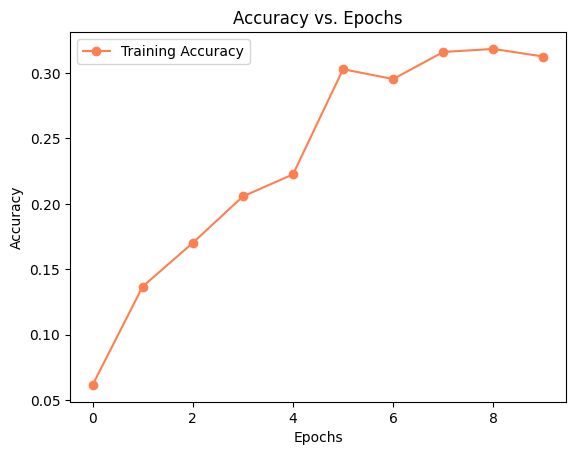

In [260]:
# plot acccuracy vs epochs
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='coral', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()